# ONLINE RETAIL ANALYSIS
**REVENUE KPI METRICS & PREDICTIONS**

----

----

## Introduction

Transactions occuring for a UK-based and registered, online retail between 01/12/2009 and 09/12/2011. 

The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

`online_retail_II.xlsx` from UCI machine learning repository.

Column | Definition
--- | -----------
Invoice     | Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
StockCode   | Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.
Description | Product (item) name.
Quantity    | The quantities of each product (item) per transaction.
InvoiceDate | Invoice date and time. The day and time when a transaction was generated.
UnitPrice   | Unit price. Product price per unit in sterling (Â£).
Customer ID | Customer number. A 5-digit integral number uniquely assigned to each customer.
Country     | Country name. The name of the country where a customer resides.

<br><br>

## Objectives (EDA & PREDICTIONS)

1. Sales and Revenue Analysis:

- Calculate the total revenue generated from the dataset.    
- Analyze the sales trends over time using InvoiceDate.
- Identify the top-selling products (and their big spenders) based on Quantity and Revenue.

2. Customer Segmentation:

- New Customer Table with Avg Order Value and Purchase Frequency (all countries).
- Churn Rate                     : The percentage of customers who have not ordered again.
- CLV (Customer Lifetime Value) : (Average Order Value x Purchase Frequency) / Churn Rate.

3. Cross-Country Analysis:

- Create a group of high-value countries. 
- Compare customer behavior and spending habits across different countries.      

4. Forecasting:

- Predictions on churn (classification).
- Forecasting of weekly sales (times-series forecasting).  

<br><br>

All the above will be applied for each year. 

We will conclude the project with a year-on-year comparison
so as to provide insights. 

----

<br><br>

*Let's import the essentials* 

In [1]:
import numpy as np 
import pandas as pd
# allow for pandas to display the full extend of rows and columns   
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns 

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from dask_ml.model_selection import GridSearchCV 
from dask_ml.preprocessing import StandardScaler

import joblib

import scikitplot as skplt

import xgboost as xgb

import itertools

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

*The Dataset*

In [2]:
def open_the_file(file):
    
    # create the excel file 
    excel  = pd.ExcelFile(file)
    print("The sheets : ", excel.sheet_names)    

    # Year 2009-2010
    first = pd.read_excel(excel, sheet_name='Year 2009-2010')
    
    # Year 2010-2011
    second = pd.read_excel(excel, sheet_name='Year 2010-2011')
    
    return first, second

In [3]:
# assign the dataframes 
df_1, df_2 = open_the_file('online_retail_II.xlsx')

The sheets :  ['Year 2009-2010', 'Year 2010-2011']


In [4]:
# since both dataframes contain the same columns let's only print the first
print(df_1.info())
df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# 

## The Plan For Data Engineering 

* DROP ALL DUPLICATES.
* FIND MISSING VALUES AND EVALUATE THEIR IMPORTANCE.
* CHECK IF THERE ARE DIFFERENT TYPES OF VALUES (COLUMNS THAT SHOULD BE NUMERIC BUT THEY ARE OBJECTS i.e).
* CHECK EXACT NUMBER OF DIGITS FOR Invoice, StockCode, CustomerID.
* NO NEGATIVE OR 0 VALUES (Quantity, Price).

<br><br>

## Data Engineering 

* DROP ALL DUPLICATES.

In [5]:
# lets build a method that accepts a dataframe and cleans the duplicates in it:
def duplicates(df):
      
      # find the percentage of duplicates
      number_of_duplicates = df.duplicated().sum()
      percentage = round(df.duplicated().sum() / len(df) * 100, 2)
      print(f"Number of duplicates : " , number_of_duplicates )
      print("The percentage of duplicated values : ", percentage, "%")
            
      # drop them all 
      df.drop_duplicates(inplace = True)
      print(df.duplicated().sum(), "duplicates now.. just checking...")

In [6]:
# check the duplicates for the first dataframe 
duplicates(df_1)

Number of duplicates :  6865
The percentage of duplicated values :  1.31 %
0 duplicates now.. just checking...


In [7]:
# check the duplicates for the second dataframe 
duplicates(df_2)

Number of duplicates :  5268
The percentage of duplicated values :  0.97 %
0 duplicates now.. just checking...


* FIND MISSING VALUES AND EVALUATE THEIR IMPORTANCE.

In [8]:
# lets find out if there are missing values 
def missing(df):
        
    # find the columns that are missing values by percentage
    missing_values = df.isnull().sum()
    missing_values_percentage = 100 * missing_values / len(df)

    # find the columns that miss values with a percentage of more than 0 
    missing_val = missing_values_percentage[missing_values_percentage > 0].sort_values(ascending=True)    
        
    print(missing_values_percentage, "\n")
    print(missing_val)
    
    # and visualize it
    plt.figure(figsize=(8,4), dpi=100)
    sns.barplot(x=missing_values.index, y=missing_values, palette='viridis')
    plt.xlabel("Columns")
    plt.ylabel("Missing values per column")
    plt.title("Counting missing values")
    plt.xticks(rotation=90) 
    plt.show()
    
    return missing_values

Invoice         0.000000
StockCode       0.000000
Description     0.564601
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    20.793257
Country         0.000000
dtype: float64 

Description     0.564601
Customer ID    20.793257
dtype: float64


C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


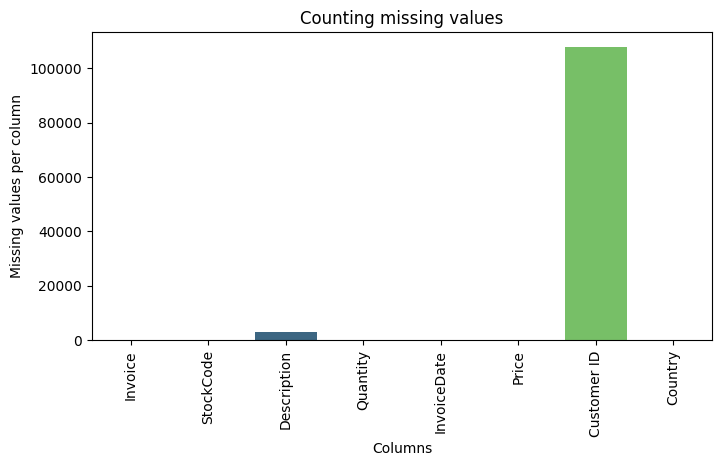

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107833
Country             0
dtype: int64

In [9]:
# see what's missing from the first one 
missing(df_1)

Invoice         0.000000
StockCode       0.000000
Description     0.270944
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    25.163330
Country         0.000000
dtype: float64 

Description     0.270944
Customer ID    25.163330
dtype: float64


C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


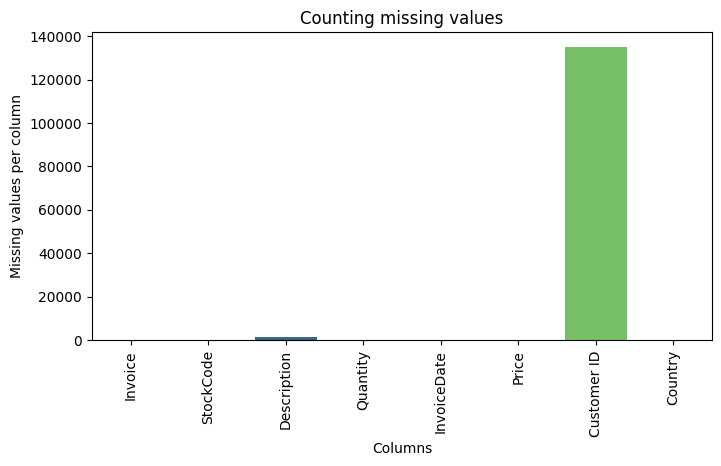

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135037
Country             0
dtype: int64

In [10]:
# see what's missing from the second one 
missing(df_2)

In [ ]:
# NOTE : We will drop the missing ones for the Customer-Centric Analysis (OBJECTIVE 2)

* CHECK IF THERE ARE DIFFERENT TYPES OF VALUES (COLUMNS THAT SHOULD BE NUMERIC BUT THEY ARE OBJECTS i.e).

In [ ]:
# NOTE:

# StockCode    =  object
# Customer ID  =  float64

# BOTH StockCode & Customer ID SHOULD BE int64.
# THERE HAS TO BE CLEANING FOR THE DIGITS. 

* CHECK EXACT NUMBER OF DIGITS FOR InvoiceNo, StockCode, CustomerID.

In [11]:
def extract_digits_stockcodes(df, series='StockCode'):
    # Extract digits
    pattern_digits = r'(\d+[.\d])'
    pattern_alphanumerics = r'\w'
    
    
    matches_digits = df[~df[series].str.match(pattern_digits, case=False, na=False)][series].to_list()
    matching_rows_digits = df[df[series].isin(matches_digits)]
    
    matches_alphanumerics = matching_rows_digits[~matching_rows_digits[series].str.match(pattern_alphanumerics, case=False, na=False)][series].to_list()
    matching_rows_final = matching_rows_digits[matching_rows_digits[series].isin(matches_alphanumerics)]

    return matching_rows_final

In [12]:
cleaned_stocks_1 = extract_digits_stockcodes(df_1)
cleaned_stocks_2 = extract_digits_stockcodes(df_2)

In [13]:
# how many products where actually ordered

# method that filters Invoice (true orders and cancellations)
def cancellations(df, series='Invoice'): 
    
    # Search for rows that start with the letter 'c' (case-insensitive) in 'Invoice' column
    pattern = r'^c'  # Start of the string followed by 'c', case-insensitive

    # Use the .str accessor to apply regex to each element in the Series
    # we are using case = False (case insensitive, it brings back either lowercase or uppercase 'c')
    matches = df[df[series].str.match(pattern, case=False, na=False)][series].to_list()
    print(f"Number of cancellations : ",  len(matches))

    # Locate the rows that are in the matches (the cancellations)
    matching_rows = df[df[series].isin(matches)]
    matching_rows_percent = len(matching_rows) / len(df[series]) * 100

    # Exclude rows (~) that match the criteria (the Invoice without the cancellations)
    filtered_data = df[~df[series].isin(matches)]
    filtered_data_percent = len(filtered_data) / len(df[series]) * 100
    
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 4))

    # Pie chart
    labels = ['Cancellations', 'Non-Cancellations']
    sizes = [matching_rows_percent, filtered_data_percent]
    colors = ['red', 'green']
    explode = (0.1, 0)

    ax.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')
    
    plt.title('Percentage of Cancellations vs. Non-Cancellations')

    plt.tight_layout()
    plt.show()
    
    return matching_rows, filtered_data

Number of cancellations :  7999


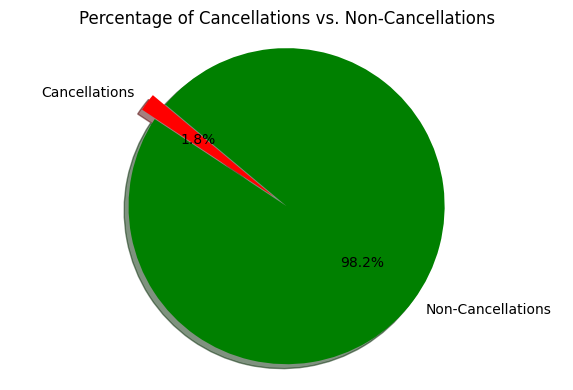

Number of cancellations :  8017


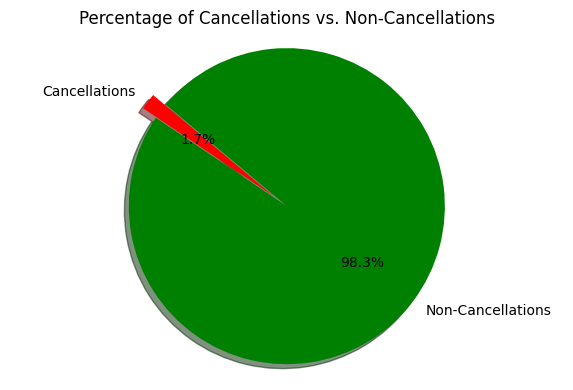

In [14]:
cancel_invoice_1, filtered_invoice_1 = cancellations(cleaned_stocks_1)
cancel_invoice_2, filtered_invoice_2 = cancellations(cleaned_stocks_2)

In [15]:
# create a method that verifies that a column has a specific number of digits
# 6 digits for Invoice (after removal of cancellations)
# 5 digits for StockCode & Customer ID

def verify_columns(df, series):
     
     for series in series:
                             
          if  series == "Customer ID" or series == "StockCode":               
               pattern = r'\d{5}'
               matching_rows = df[df[series].astype(str).str.contains(pattern, case=False, na=False)]
               
          elif series == "Invoice":               
               pattern = r'\d{6}'
               matching_rows = df[df[series].astype(str).str.contains(pattern, case=False, na=False)]          
              
     return matching_rows

In [16]:
filtered_invoice_1 = verify_columns(filtered_invoice_1, ['Customer ID', 'StockCode', 'Invoice'])

In [17]:
filtered_invoice_2 = verify_columns(filtered_invoice_2, ['Customer ID', 'StockCode', 'Invoice'])

* NO NEGATIVE OR 0 VALUES (Quantity, Price).

In [18]:
# remove negative values from Quantity and Price column
def find_negatives(df, series=['Quantity', 'Price']):
    
    for series in series:
        negatives = df[df[series] <= 0] 
    
    return negatives

In [19]:
df_1 = filtered_invoice_1.drop(find_negatives(filtered_invoice_1).index, axis=0)

In [20]:
df_2 = filtered_invoice_2.drop(find_negatives(filtered_invoice_2).index, axis=0)

In [ ]:
# NOTE : 
# Negative quantitity does not correlate with cancellations !! 
# Even after removal of cancellations there were still rows with negative quantities .

# 

In [21]:
# lets make Quantity float type SINCE Customer ID and Price are floats.. 
def float_quantity(df, series = 'Quantity'):
    df[series] = df[series].astype('float64')
    return df

In [22]:
df_1 = float_quantity(df_1)
df_1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24.0,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [23]:
df_2 = float_quantity(df_2)
df_2.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.0,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6.0,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6.0,2010-12-01 08:28:00,1.85,17850.0,United Kingdom


### THE CLEANED DATAFRAMES WILL BE USED FOR THE EDA. 

In [24]:
df_1.to_csv('cleaned_retail_1.csv')
df_2.to_csv('cleaned_retail_2.csv')

## EDA  

In [25]:
# upload the cleaned datasets
df_1 = pd.read_csv('cleaned_retail_1.csv', parse_dates=['InvoiceDate'])
df_1.drop('Unnamed: 0', axis = 1, inplace=True)

df_2 = pd.read_csv('cleaned_retail_2.csv', parse_dates=['InvoiceDate'])
df_2.drop('Unnamed: 0', axis = 1, inplace=True)

1. Sales and Revenue Analysis:

- Calculate the total revenue generated from the dataset.

  Σ(quantity of product * total price of product) for all products

In [26]:
# so how many unique products are there on Year 1
unique_products_1 = [prod for prod in df_1['Description'].unique()]
print('Number of unique products : ', len(unique_products_1))

Number of unique products :  3141


In [27]:
# so how many unique products are there on Year 2
unique_products_2 = [prod for prod in df_2['Description'].unique()]
print('Number of unique products : ', len(unique_products_2))

Number of unique products :  3069


In [28]:
# firstly define a function that creates a new column named total_price   
def total_price(Quantity, Price):
    total_price = Quantity * Price
    return total_price

In [29]:
# first year
df_1['total_price'] = np.vectorize(total_price)(df_1['Quantity'], df_1['Price'])
df_1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
2,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0
3,489434,22064,PINK DOUGHNUT TRINKET POT,24.0,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,39.6
4,489434,21871,SAVE THE PLANET MUG,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [31]:
# the total revenue of the first Year !
total_revenue_1 = np.sum(df_1['total_price'])
print("Revenue year 1 : ", round(total_revenue_1, 2), 'pounds')

Revenue year 1 :  8295796.4 pounds


In [32]:
# second year
df_2['total_price'] = np.vectorize(total_price)(df_2['Quantity'], df_2['Price'])
df_2.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,total_price
0,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.0,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
2,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
3,536366,22633,HAND WARMER UNION JACK,6.0,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
4,536366,22632,HAND WARMER RED POLKA DOT,6.0,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10


In [34]:
# the total revenue of the second Year !
total_revenue_2 = np.sum(df_2['total_price'])
print("Revenue year 2 : ", round(total_revenue_2, 2), 'pounds')

Revenue year 2 :  9345497.67 pounds


In [50]:
revenue_diff = np.abs(total_revenue_1 - total_revenue_2)
print("Revenue difference : ", round(revenue_diff, 2))

# NOTE : YEAR 2 GREATER REVENUE BY 1049701.27 POUNDS

Revenue difference :  1049701.27


In [51]:
# Let's make a copy of the dataframes for future reference
df_1_with_total_price = df_1.copy()
df_2_with_total_price = df_2.copy()

- Analyze the sales trends over time using InvoiceDate.

In [52]:
# WEEKLY GROUPING OF TOTAL SALES 

weekly_sales_1 = df_1.resample('W-Mon', on='InvoiceDate').sum()
weekly_sales_2 = df_2.resample('W-Mon', on='InvoiceDate').sum()

# Convert the relevant columns to NumPy arrays
sales_1 = np.array(weekly_sales_1['Quantity'] * weekly_sales_1['Price'])
sales_2 = np.array(weekly_sales_2['Quantity'] * weekly_sales_2['Price'])

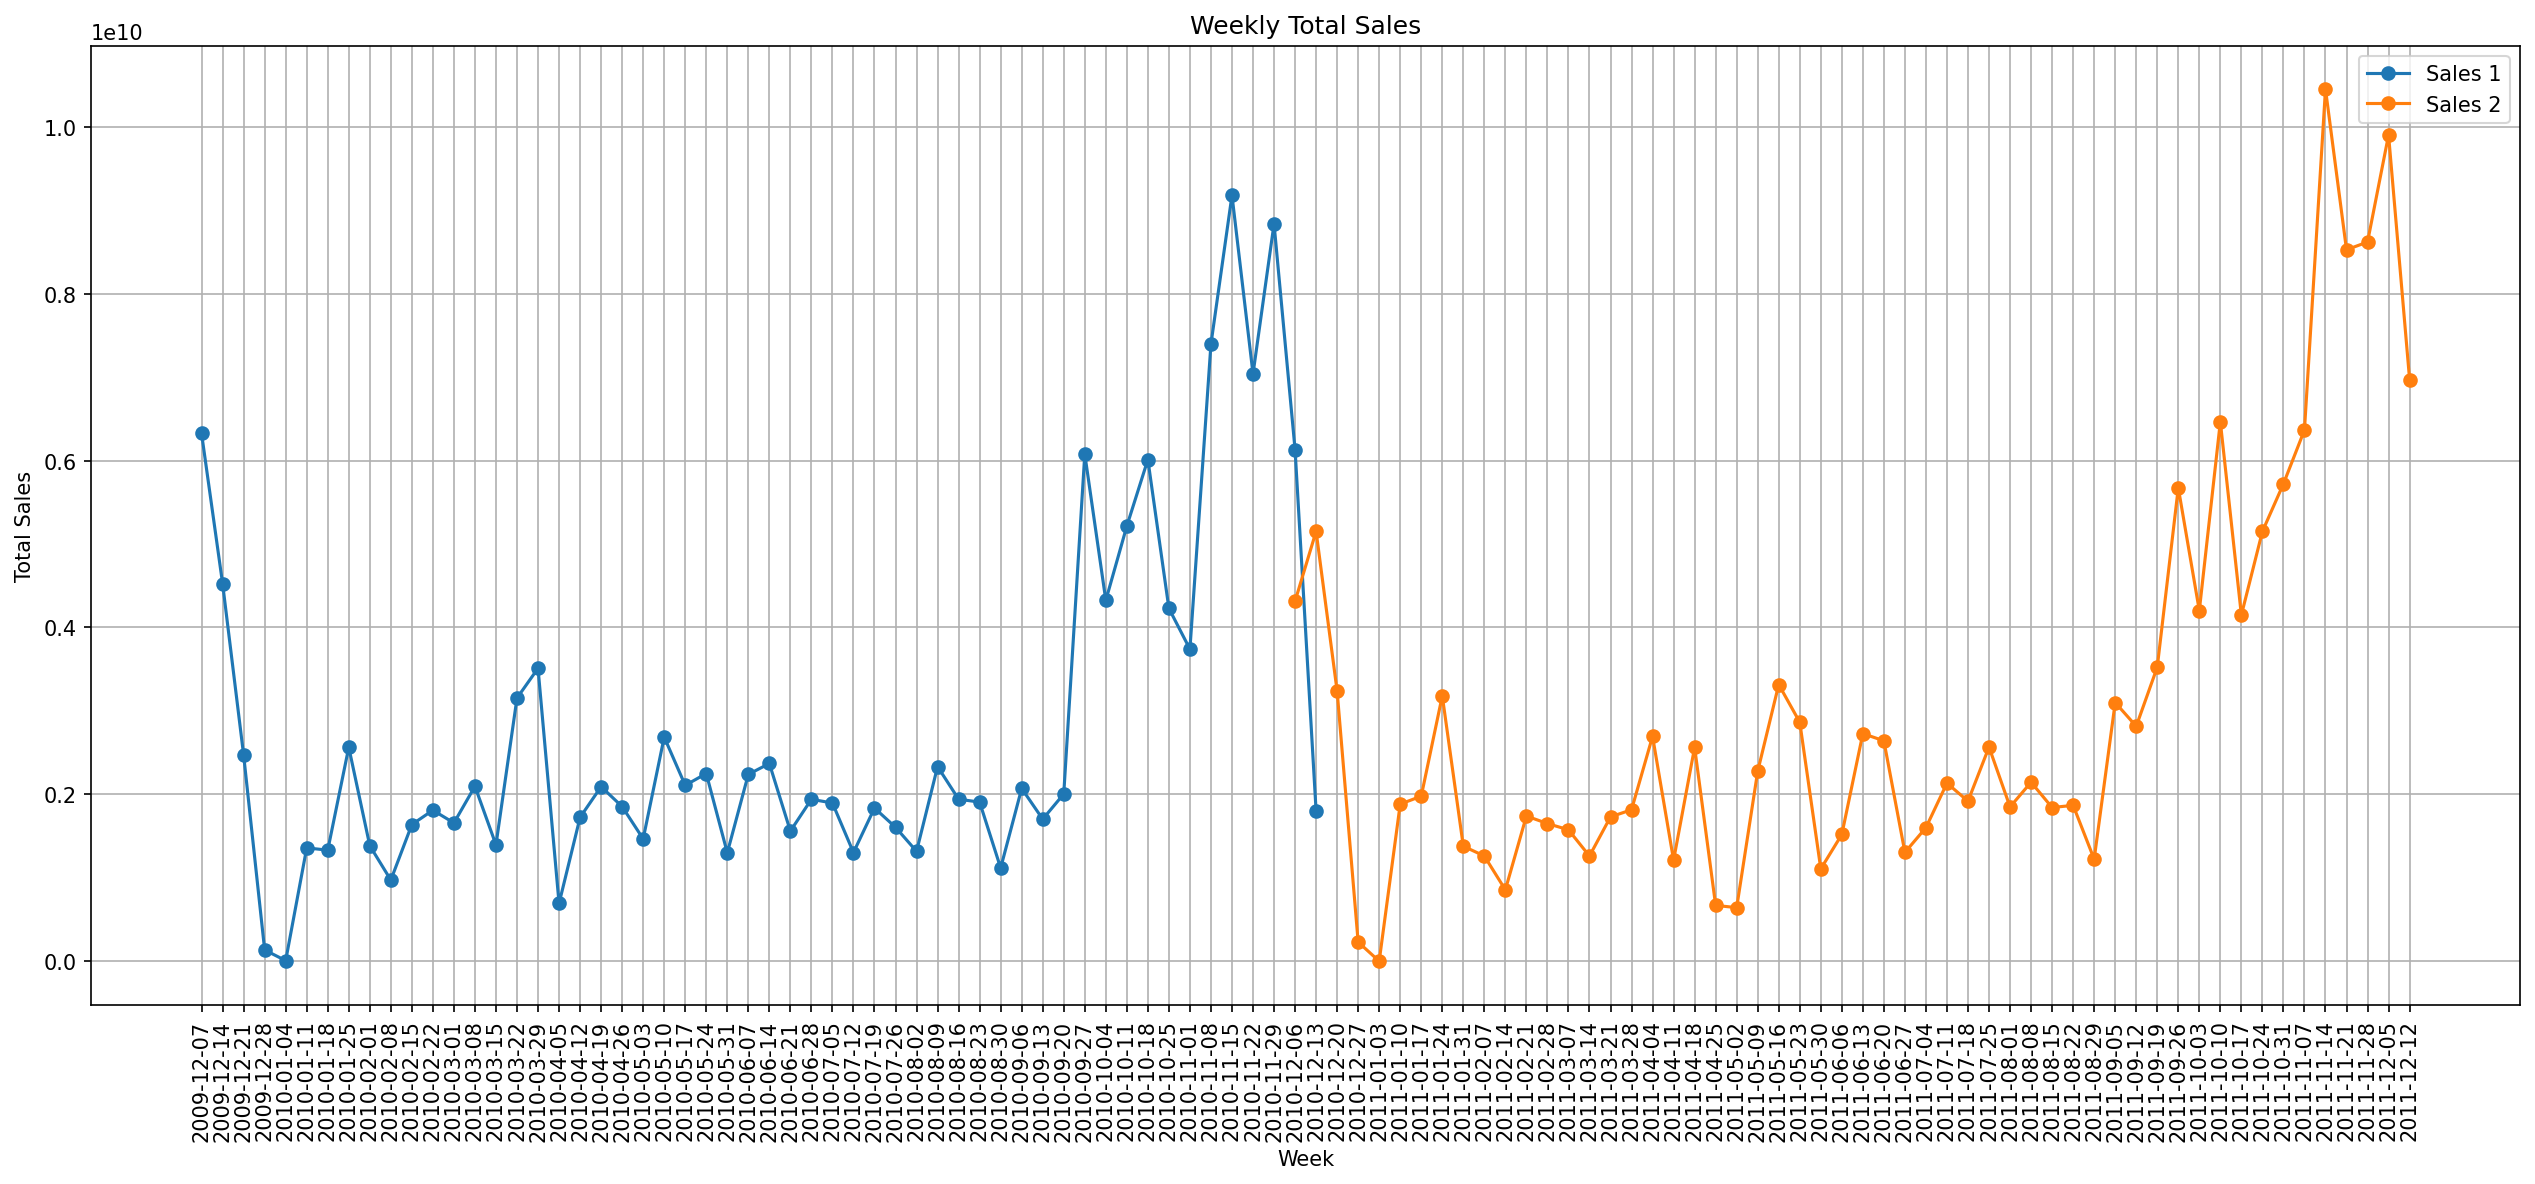

In [55]:
# Visualize weekly total sales

# Convert the index to a list of strings
weeks_1 = np.array(weekly_sales_1.index.strftime('%Y-%m-%d'))
# Convert the index to a list of strings
weeks_2 = np.array(weekly_sales_2.index.strftime('%Y-%m-%d'))

plt.figure(figsize=(17, 8), dpi=150)
plt.plot(weeks_1, sales_1, marker='o', label='Sales 1')
plt.plot(weeks_2, sales_2, marker='o', label='Sales 2')
plt.title('Weekly Total Sales')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# NOTE : 
# Big increase in sales on October. Then even bigger from 2nd week of November up to 3d week od December for both.
# Major sales on November and December.

- Identify the top-selling products based on Quantity and Revenue.

In [56]:
# lets find the top 50 selling products with their spenders  

def top_selling(df):
    
    product_metrics = df.groupby('StockCode').agg({
        'Description': 'first',
        'Quantity': 'sum',
        'Price': 'first',  # Assuming Price remains the same for a product
    })
    
    product_metrics['Revenue'] = product_metrics['Quantity'] * product_metrics['Price']
    return product_metrics.sort_values(by = 'Revenue', ascending=False)[:50]

In [57]:
# top 50 selling countries for Year 1
top_50_year_1  = top_selling(df_1)
top_50_year_1

,Description,Quantity,Price,Revenue
StockCode,,,,
22423,REGENCY CAKESTAND 3 TIER,13685.0,12.75,174483.75
37340,MULTICOLOUR SPRING FLOWER MUG,11130.0,8.65,96274.50
21843,RETRO SPOT CAKE STAND,4251.0,21.70,92246.70
84879,ASSORTED COLOUR BIRD ORNAMENT,45228.0,1.69,76435.32
79321,CHILLI LIGHTS,6461.0,10.39,67129.79
22188,BLACK HEART CARD HOLDER,7613.0,8.65,65852.45
37351,ORANGE FLOWER MUG,5394.0,11.26,60736.44
84347,ROTATING SILVER ANGELS T-LIGHT HLDR,23037.0,2.55,58744.35
22086,PAPER CHAIN KIT 50'S CHRISTMAS,17205.0,2.95,50754.75


In [58]:
# top 50 selling countries for Year 2
top_50_year_2 = top_selling(df_2)
top_50_year_2

,Description,Quantity,Price,Revenue
StockCode,,,,
47566,PARTY BUNTING,18283.0,9.32,170397.56
23843,"PAPER CRAFT , LITTLE BIRDIE",80995.0,2.08,168469.60
22423,REGENCY CAKESTAND 3 TIER,13851.0,10.95,151668.45
23166,MEDIUM CERAMIC TOP STORAGE JAR,78033.0,1.04,81154.32
23084,RABBIT NIGHT LIGHT,30739.0,2.08,63937.12
84879,ASSORTED COLOUR BIRD ORNAMENT,36362.0,1.69,61451.78
22944,CHRISTMAS METAL POSTCARD WITH BELLS,3375.0,16.13,54438.75
22086,PAPER CHAIN KIT 50'S CHRISTMAS,19329.0,2.55,49288.95
84946,ANTIQUE SILVER TEA GLASS ETCHED,19209.0,2.51,48214.59


# 

2. Customer Segmentation:

In [59]:
# Before anything let's drop the missing rows from Customer ID columns
missing_1 = df_1[df_1['Customer ID'].isnull()]
missing_2 = df_2[df_2['Customer ID'].isnull()]

In [60]:
df_1 = df_1.drop(missing_1.index)
df_1.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
total_price    0
dtype: int64

In [61]:
df_2 = df_2.drop(missing_2.index)
df_2.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
total_price    0
dtype: int64

- New Customer Table with Avg Order Value and Purchase Frequency (all countries)

###### Avg order value:  The ratio of money spent to the number of transactions
###### Purchase Frequency: This is the ratio of the sum of transactions to the total number of unique customers

In [62]:
def new_table(df):
    aggregated_data = df.groupby(['Customer ID', 'Country'])[['Quantity', 'total_price']].sum()
    
    # num of transactions 
    aggregated_data['num_of_transactions'] = df.groupby(['Customer ID', 'Country'])['Invoice'].nunique()

    # num of days active  (max date - min date in days)
    aggregated_data['num_of_active_days'] = df.groupby(['Customer ID', 'Country'])['InvoiceDate'].apply(lambda x: (x.max() - x.min()).days)
    
    # Calculate average order value
    aggregated_data['avg_order_value'] = round(aggregated_data['total_price'] / aggregated_data['num_of_transactions'], 2)
    
    # Calculate purchase frequency
    total_customers = aggregated_data.index.get_level_values('Customer ID').nunique() # total unique customers
    aggregated_data['purchase_freq'] =aggregated_data['num_of_transactions'] / total_customers 
    
    return aggregated_data

In [63]:
new_table_1 = new_table(df_1)
new_table_2 = new_table(df_2)

# NOTE : WHEN A Customer ID IS BLANK THEN THAT CUSTOMER IS RESIDENT TO ANOTHER COUNTRY, SO WE SHOULD AGGREGATE THE DATA FOR THAT CUSTOMER.

In [64]:
new_table_1.head()

,,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq
Customer ID,Country,,,,,,
12346.0,United Kingdom,20.0,144.02,2,118,72.01,0.000471
12347.0,Iceland,653.0,966.87,2,37,483.44,0.000471
12348.0,Finland,372.0,221.16,1,0,221.16,0.000235
12349.0,Italy,896.0,1946.64,2,181,973.32,0.000471
12351.0,Unspecified,261.0,300.93,1,0,300.93,0.000235


In [65]:
new_table_2.head()

,,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq
Customer ID,Country,,,,,,
12346.0,United Kingdom,74215.0,77183.60,1,0,77183.60,0.000232
12347.0,Iceland,2137.0,3653.45,7,365,521.92,0.001623
12348.0,Finland,2332.0,1437.24,4,282,359.31,0.000927
12349.0,Italy,611.0,1372.42,1,0,1372.42,0.000232
12350.0,Norway,168.0,258.00,1,0,258.00,0.000232


In [66]:
def group_multiple_country_customers(df):
    
    # First, let's reset the index of the DataFrame if necessary
    df.reset_index(inplace=True)

    # Group by 'Customer ID' and count the number of unique countries
    customer_country_counts = df.groupby('Customer ID')['Country'].nunique()

    # Locate customer IDs with more than 1 country
    customer_ids_with_multiple_countries = customer_country_counts[customer_country_counts > 1].index.tolist()

    # Now 'customer_ids_with_multiple_countries' contains the IDs of customers with more than 1 associated country 
    return customer_ids_with_multiple_countries

In [67]:
multiple_country_ids_1 = group_multiple_country_customers(new_table_1)
multiple_country_ids_2 = group_multiple_country_customers(new_table_2)

In [68]:
# lets keep a track of the customers with more than one country for year 1
multiple_country_ids_1 = new_table_1[new_table_1['Customer ID'].isin(multiple_country_ids_1)]
multiple_country_ids_1

,Customer ID,Country,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq
49,12417.0,Belgium,975.0,2162.85,10,323,216.28,0.002354
50,12417.0,Spain,84.0,118.20,1,0,118.20,0.000235
54,12422.0,Australia,1102.0,1304.95,4,296,326.24,0.000942
55,12422.0,Switzerland,970.0,1388.68,5,173,277.74,0.001177
56,12423.0,Belgium,368.0,404.28,1,0,404.28,0.000235
57,12423.0,Denmark,62.0,195.30,1,0,195.30,0.000235
63,12431.0,Australia,918.0,2373.82,9,272,263.76,0.002119
64,12431.0,Belgium,642.0,1204.98,2,185,602.49,0.000471


In [69]:
# lets keep a track of the customers with more than one country for year 2
multiple_country_ids_2 = new_table_2[new_table_2['Customer ID'].isin(multiple_country_ids_2)]
multiple_country_ids_2

,Customer ID,Country,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq
20,12370.0,Austria,48.0,157.20,1,0,157.20,0.000232
21,12370.0,Cyprus,2072.0,2814.51,3,309,938.17,0.000695
39,12394.0,Belgium,180.0,351.08,1,0,351.08,0.000232
40,12394.0,Denmark,628.0,729.40,1,0,729.40,0.000232
58,12417.0,Belgium,1151.0,2637.25,8,354,329.66,0.001854
59,12417.0,Spain,226.0,298.80,1,0,298.80,0.000232
63,12422.0,Australia,185.0,366.70,2,229,183.35,0.000464
64,12422.0,Switzerland,160.0,287.40,1,0,287.40,0.000232
71,12429.0,Austria,196.0,381.98,1,0,381.98,0.000232
72,12429.0,Denmark,1210.0,2830.86,3,356,943.62,0.000695


- Churn Rate                     : The percentage of customers who have not ordered again. 

In [70]:
# Let's create the churn column

def churn_column(df):

    # iterating over each row using the iterrows() method.
    for index, row in df.iterrows():
        
        # For rows with num_of_transactions greater than 1, 
        # I calculate the churn rate as 1 minus the reciprocal of the number of transactions.
        if row['num_of_transactions'] > 1:
            repeat_rate = 1 - 1 / row['num_of_transactions']
            df.at[index, 'churn_rate'] = round(repeat_rate, 2)
            
        else:            
            #For rows with only 1 transaction, I set the churn rate to 1.0 (100% churn).
            df.at[index, 'churn_rate'] = 1.0
    
    return df

In [71]:
new_table_1 = churn_column(new_table_1)
new_table_1.head(15)

,Customer ID,Country,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq,churn_rate
0,12346.0,United Kingdom,20.0,144.02,2,118,72.01,0.000471,0.50
1,12347.0,Iceland,653.0,966.87,2,37,483.44,0.000471,0.50
2,12348.0,Finland,372.0,221.16,1,0,221.16,0.000235,1.00
3,12349.0,Italy,896.0,1946.64,2,181,973.32,0.000471,0.50
4,12351.0,Unspecified,261.0,300.93,1,0,300.93,0.000235,1.00
5,12352.0,Norway,176.0,332.40,2,16,166.20,0.000471,0.50
6,12353.0,Bahrain,192.0,317.76,1,0,317.76,0.000235,1.00
7,12355.0,Bahrain,247.0,329.41,1,0,329.41,0.000235,1.00
8,12356.0,Portugal,1320.0,2090.63,3,44,696.88,0.000706,0.67
9,12357.0,Switzerland,3714.0,10468.27,1,0,10468.27,0.000235,1.00


In [72]:
new_table_2 = churn_column(new_table_2)
new_table_2.head(15)

,Customer ID,Country,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq,churn_rate
0,12346.0,United Kingdom,74215.0,77183.60,1,0,77183.60,0.000232,1.00
1,12347.0,Iceland,2137.0,3653.45,7,365,521.92,0.001623,0.86
2,12348.0,Finland,2332.0,1437.24,4,282,359.31,0.000927,0.75
3,12349.0,Italy,611.0,1372.42,1,0,1372.42,0.000232,1.00
4,12350.0,Norway,168.0,258.00,1,0,258.00,0.000232,1.00
5,12352.0,Norway,516.0,1373.24,7,260,196.18,0.001623,0.86
6,12353.0,Bahrain,20.0,89.00,1,0,89.00,0.000232,1.00
7,12354.0,Spain,526.0,1062.80,1,0,1062.80,0.000232,1.00
8,12355.0,Bahrain,210.0,363.10,1,0,363.10,0.000232,1.00
9,12356.0,Portugal,1493.0,2406.63,3,302,802.21,0.000695,0.67


- CLV (Customer Lifetime Value) : (Average Order Value x Purchase Frequency) / Churn Rate

In [73]:
def CLV(df):
    
    # Customer Value
    df['CLV'] = round((df['avg_order_value'] * df['purchase_freq']) / df['churn_rate'], 2)
    
    return df

In [74]:
new_table_1 = CLV(new_table_1)
new_table_1.sort_values(by = ['CLV'], ascending=False)[:15]

,Customer ID,Country,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq,churn_rate,CLV
4125,18102.0,United Kingdom,105107.0,299485.80,88,373,3403.25,0.020716,0.99,71.21
1613,14646.0,Netherlands,153248.0,215636.54,71,362,3037.13,0.016714,0.99,51.27
1251,14156.0,EIRE,98163.0,165521.01,85,359,1947.31,0.020009,0.99,39.36
1812,14911.0,EIRE,62658.0,123371.13,182,373,677.86,0.042844,0.99,29.34
925,13694.0,United Kingdom,81378.0,82216.05,79,361,1040.71,0.018597,0.99,19.55
1922,15061.0,United Kingdom,47196.0,77346.43,86,371,899.38,0.020245,0.99,18.39
3692,17511.0,United Kingdom,48324.0,71961.08,30,369,2398.70,0.007062,0.97,17.46
3083,16684.0,United Kingdom,46532.0,62826.33,25,352,2513.05,0.005885,0.96,15.41
3652,17450.0,United Kingdom,13979.0,50259.38,7,70,7179.91,0.001648,0.86,13.76
3131,16754.0,United Kingdom,59648.0,51840.06,28,269,1851.43,0.006591,0.96,12.71


In [75]:
new_table_2 = CLV(new_table_2)
new_table_2.sort_values(by = ['CLV'], ascending=False)[:15]

,Customer ID,Country,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq,churn_rate,CLV
3006,16446.0,United Kingdom,80997.0,168472.50,2,204,84236.25,0.000464,0.50,78.11
1692,14646.0,Netherlands,189631.0,265106.92,71,353,3733.90,0.016458,0.99,62.07
4187,18102.0,United Kingdom,62811.0,253922.76,60,366,4232.05,0.013908,0.98,60.06
3720,17450.0,United Kingdom,65779.0,180687.03,46,359,3927.98,0.010663,0.98,42.74
57,12415.0,Australia,75558.0,121265.99,20,313,6063.30,0.004636,0.95,29.59
1881,14911.0,EIRE,74163.0,125430.46,198,372,633.49,0.045897,0.99,29.37
1336,14156.0,EIRE,55027.0,113029.11,52,319,2173.64,0.012054,0.98,26.74
3763,17511.0,United Kingdom,59033.0,80952.39,30,370,2698.41,0.006954,0.97,19.35
0,12346.0,United Kingdom,74215.0,77183.60,1,0,77183.60,0.000232,1.00,17.89
2700,16029.0,United Kingdom,35867.0,65153.49,61,335,1068.09,0.014140,0.98,15.41


In [76]:
# save the tables: 
new_table_1.to_csv('complete_1.csv')
new_table_2.to_csv('complete_2.csv')

3. Cross-Country Analysis:

- Create a group of high-value countries

In [ ]:
# WE WILL NEED TO COME BACK TO THE CLEANED VERSIONS THAT CONTAIN THE MISSING VALUES SINCE THIS IS A COUNTRY-BASED-ANALYSIS. 

# 

# 

##### A. Consistency 

In [77]:
# we will exclude the United Kingdom from the equation, since we want only the customers from the rest of the world  
def which_country(df):
    # Filter the DataFrame to exclude rows where the Country is "United Kingdom"
    selected = df[df["Country"] != "United Kingdom"]
    
    # Count the products for each country
    selected_data = selected["Country"].value_counts().reset_index()
    selected_data.columns = ["Country", "Counting Products"]

    # Set the style of seaborn
    sns.set(style="whitegrid")

    # Create the bar plot with error bars
    plt.figure(figsize=(20, 6))
    ax = sns.barplot(data=selected_data, x="Country", y="Counting Products", palette="Set1", ci="sd")

    # Add labels and title
    plt.xlabel("Country")
    plt.ylabel("Product Count")
    plt.title("Product Count by Country")

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90)

    # Add data labels to the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9),
                    textcoords='offset points', fontsize=9)

    # Show the plot
    plt.tight_layout()
    plt.show()

C:\Users\kon17\AppData\Local\Temp\ipykernel_28424\1253627561.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=selected_data, x="Country", y="Counting Products", palette="Set1", ci="sd")
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

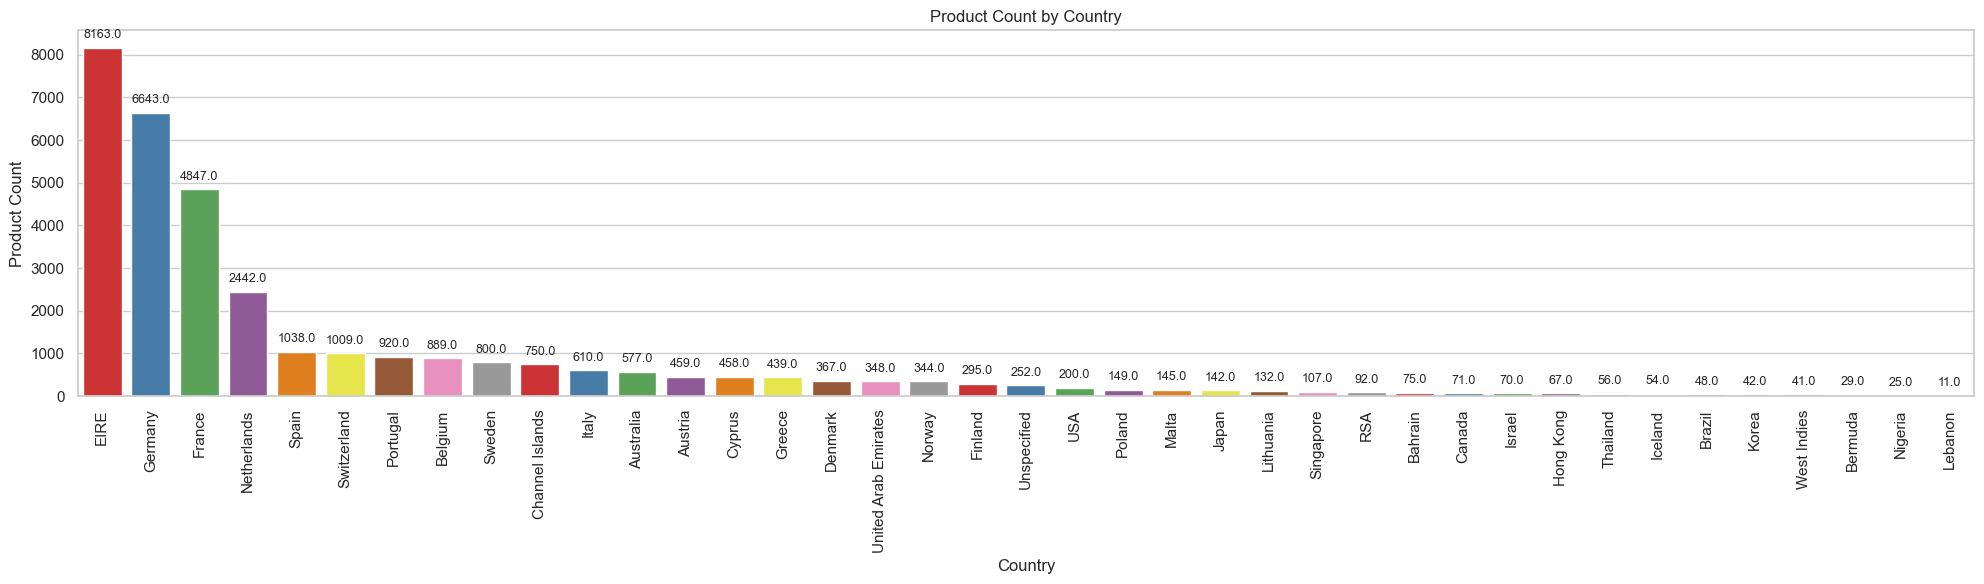

In [78]:
which_country(df_1_with_total_price)

C:\Users\kon17\AppData\Local\Temp\ipykernel_28424\1253627561.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data=selected_data, x="Country", y="Counting Products", palette="Set1", ci="sd")
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

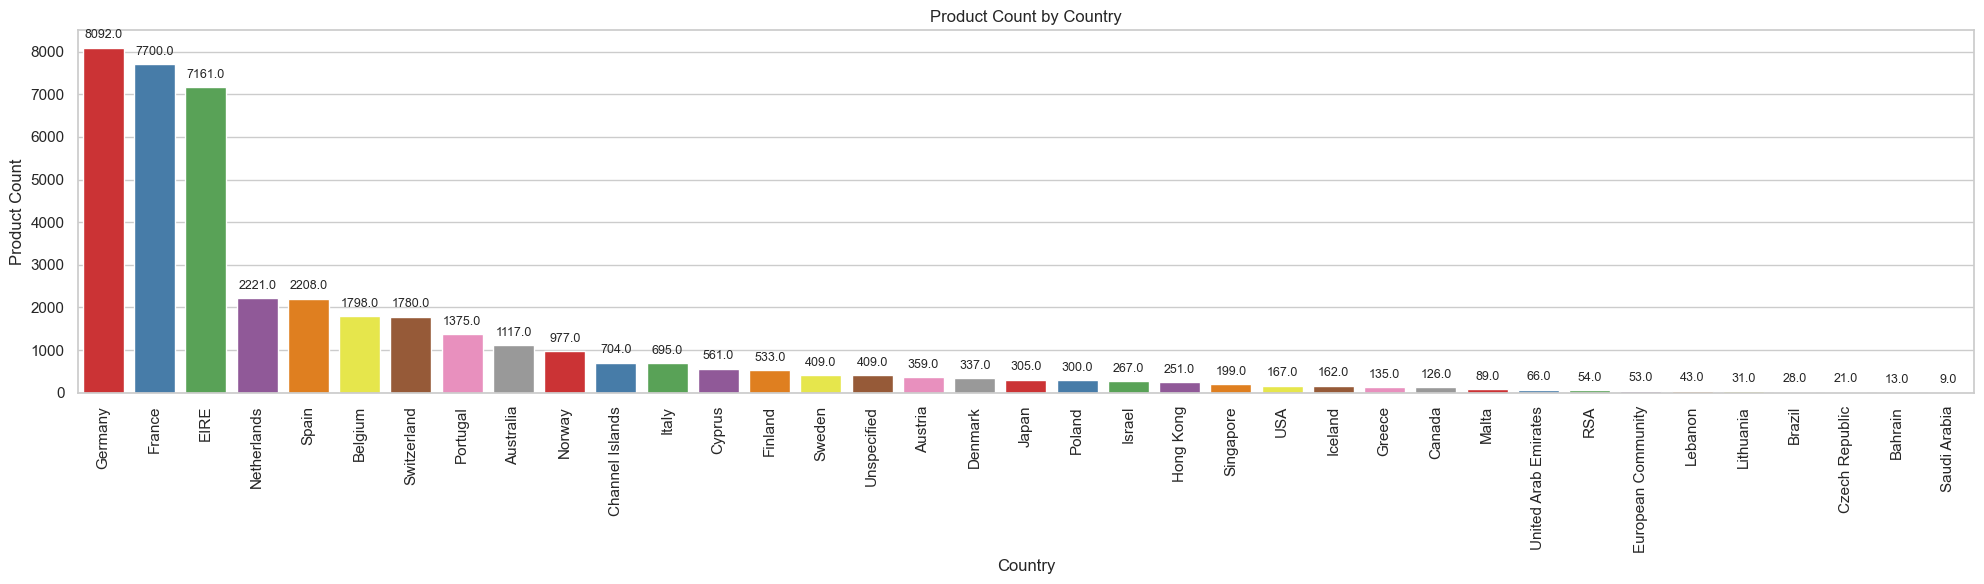

In [79]:
which_country(df_2_with_total_price)

In [ ]:
"""
NOTE : 
1. EIRE, GERMANY, FRANCE always on top 3.
2. Year 2, Germany takes the lead from EIRE, France climbs to second place and EIRE falls to third place.
3. Netherlands and Spain with places 4 and 5 respectively for both years.
4. Less products for Netherlands and more (+ ~1000) for Spain for Year 2.
"""

In [80]:
# top 5 countries + United Kingdom (reagrdind buying consistency)
top_6_countries = ['United Kingdom', 'EIRE', 'Germany', 'France', 'Netherlands', 'Spain']

##### B. Revenue

In [81]:
# lets find the top 6 countries regarding total revenue   

# lets modify the function of top selling products to identify the top countries regarding revenue  

def top_selling_revenue_countries(df):
    
    product_metrics = df.groupby('Country').agg({                
        'total_price': 'sum'  
    })
    
    product_metrics.columns = ['total_year_revenue']            
    return product_metrics.sort_values(by = 'total_year_revenue', ascending=False)[:6]

In [82]:
top_6_revenue_countries_1 =  top_selling_revenue_countries(df_1_with_total_price)
top_6_revenue_countries_1

,total_year_revenue
Country,
United Kingdom,7109405.74
EIRE,314967.04
Netherlands,231653.15
Germany,164307.26
France,114149.39
Sweden,46632.17


In [83]:
top_6_revenue_countries_2 =  top_selling_revenue_countries(df_2_with_total_price)
top_6_revenue_countries_2

,total_year_revenue
Country,
United Kingdom,7928438.03
Netherlands,269330.18
EIRE,255651.51
Germany,190013.20
France,174110.49
Australia,134003.12


In [ ]:
# BEFORE ANYTHING LET'S CREATE DATAFRAMES CONTAINING TOTAL PRICE AND ENCODED COUNTRIES 

In [84]:
# let's make Country column dummy type
def dummy_country(df, series='Country'):        
    df_encoded = pd.get_dummies(df, columns=[series])
    return df_encoded    

In [85]:
df_1_encoded = dummy_country(df_1_with_total_price)
df_2_encoded = dummy_country(df_2_with_total_price)

In [86]:
df_1_encoded.to_csv('cleaned_retail_with_dummies_1.csv')
df_2_encoded.to_csv('cleaned_retail_with_dummies_2.csv')

- Compare customer behavior and spending habits across different countries.

# 

        1. 10 most Popular Products by Country: Identify the top-selling products in each of top 6 countries.

In [87]:
# Combining the three lists using zip
top_6_countries_final = list(zip(top_6_countries, top_6_revenue_countries_1.index, top_6_revenue_countries_2.index))

# Create an empty set to store unique country names
unique_countries = set()

# Iterate through the tuples and add their elements to the set
for tuple_item in top_6_countries_final:
    unique_countries.update(tuple_item)

# Convert the set to a list
unique_countries_list = list(unique_countries)
# add the prefix to be in accordance with Country_ column 
unique_countries_list = ['Country_' + country for country in unique_countries_list]
unique_countries_list

['Country_Spain',
 'Country_Netherlands',
 'Country_Sweden',
 'Country_EIRE',
 'Country_United Kingdom',
 'Country_France',
 'Country_Australia',
 'Country_Germany']

In [88]:
 # a small modification to the existing function 
def top_selling_per_country(df):
    
    # pattern for finding Country_ columns 
    country_columns = df.columns[df.columns.str.startswith("Country_")]
    top_products_per_country = {}

    for country in country_columns:
        country_df = df[df[country] == 1]  # Filter data for the specific country
        country_top_products = country_df.groupby(['StockCode', 'Description']).agg({
            'Quantity': 'sum',
            'Price': 'first'
        }).reset_index().sort_values(by='Quantity', ascending=False).head(10)
        
        top_products_per_country[country] = country_top_products

    return top_products_per_country

In [89]:
def print_top_selling_per_country_for_top_10(df):
            
    for country, products in top_selling_per_country(df=df).items():
        if country in (unique_countries_list):                                
            print(f"Top products in {country}: \n")
            print(products)
            print("=" * 10)

In [90]:
top_products_year_1 = print_top_selling_per_country_for_top_10(df_1_encoded)

Top products in Country_Australia: 

     StockCode                         Description  Quantity  Price
371      22951     60 CAKE CASES DOLLY GIRL DESIGN     504.0   0.55
323      22711                  WRAP CIRCUS PARADE     425.0   0.42
42       21121   SET/10 RED POLKADOT PARTY CANDLES     336.0   1.25
44       21122  SET/10 PINK POLKADOT PARTY CANDLES     336.0   1.25
48       21124  SET/10 BLUE POLKADOT PARTY CANDLES     336.0   1.25
102      21731       RED TOADSTOOL LED NIGHT LIGHT     324.0   1.65
266      22539              MINI JIGSAW DOLLY GIRL     312.0   0.42
267      22540          MINI JIGSAW CIRCUS PARADE      312.0   0.42
294      22630                DOLLY GIRL LUNCH BOX     292.0   1.95
269      22544                MINI JIGSAW SPACEBOY     288.0   0.42
Top products in Country_EIRE: 

      StockCode                         Description  Quantity  Price
297       21212    PACK OF 72 RETRO SPOT CAKE CASES    4080.0   0.55
1732      84991         60 TEATIME FAIRY CAKE

In [91]:
top_products_year_2 = print_top_selling_per_country_for_top_10(df_2_encoded)

Top products in Country_Australia: 

     StockCode                    Description  Quantity  Price
222      22492        MINI PAINT SET VINTAGE     2952.0   0.55
395      23084             RABBIT NIGHT LIGHT    1884.0   2.08
105      21915         RED  HARMONICA IN BOX     1704.0   1.06
87       21731  RED TOADSTOOL LED NIGHT LIGHT    1344.0   1.45
365      22969   HOMEMADE JAM SCENTED CANDLES    1080.0   1.45
264      22630           DOLLY GIRL LUNCH BOX    1024.0   1.65
263      22629            SPACEBOY LUNCH BOX      960.0   1.65
241      22544           MINI JIGSAW SPACEBOY     720.0   0.36
104      21914         BLUE HARMONICA IN BOX      720.0   1.06
260      22620    4 TRADITIONAL SPINNING TOPS     700.0   1.06
Top products in Country_EIRE: 

      StockCode                         Description  Quantity  Price
176       21212     PACK OF 72 RETROSPOT CAKE CASES    1800.0   0.55
1706      84991         60 TEATIME FAIRY CAKE CASES    1536.0   0.55
368       21790                

# 

4. Forecasting:

In [92]:
# USING CLEAN DATAFRAME  (WE WANT TO INCLUDE InvoiceDate) 
year_1 = pd.read_csv('cleaned_retail_1.csv', parse_dates=['InvoiceDate'])
year_1 = year_1.drop('Unnamed: 0', axis=1)

year_2 = pd.read_csv('cleaned_retail_2.csv' , parse_dates=['InvoiceDate'])
year_2 = year_2.drop('Unnamed: 0', axis=1)

- Predictions on churn (classification).

In [93]:
# first let's split each dataset from jan to jun and jul to dec
year_1_jan_to_jun = year_1[year_1['InvoiceDate'] <= '2010-06-30']
year_1_jul_to_dec = year_1[year_1['InvoiceDate'] > '2010-06-30']

In [94]:
year_2_jan_to_jun = year_2[year_2['InvoiceDate'] <= '2011-06-30']
year_2_jul_to_dec = year_2[year_2['InvoiceDate'] > '2011-06-30']

In [95]:
# add total_price to all tables 
year_1_jan_to_jun['total_price'] = np.vectorize(total_price)(year_1_jan_to_jun['Quantity'], year_1_jan_to_jun['Price'])
year_1_jul_to_dec['total_price'] = np.vectorize(total_price)(year_1_jul_to_dec['Quantity'], year_1_jul_to_dec['Price'])

C:\Users\kon17\AppData\Local\Temp\ipykernel_28424\4123652878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_1_jan_to_jun['total_price'] = np.vectorize(total_price)(year_1_jan_to_jun['Quantity'], year_1_jan_to_jun['Price'])
C:\Users\kon17\AppData\Local\Temp\ipykernel_28424\4123652878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_1_jul_to_dec['total_price'] = np.vectorize(total_price)(year_1_jul_to_dec['Quantity'], year_1_jul_to_dec['Price'])


In [96]:
# add total_price to all tables 
year_2_jan_to_jun['total_price'] = np.vectorize(total_price)(year_2_jan_to_jun['Quantity'], year_2_jan_to_jun['Price'])
year_2_jul_to_dec['total_price'] = np.vectorize(total_price)(year_2_jul_to_dec['Quantity'], year_2_jul_to_dec['Price'])

C:\Users\kon17\AppData\Local\Temp\ipykernel_28424\2022397842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2_jan_to_jun['total_price'] = np.vectorize(total_price)(year_2_jan_to_jun['Quantity'], year_2_jan_to_jun['Price'])
C:\Users\kon17\AppData\Local\Temp\ipykernel_28424\2022397842.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2_jul_to_dec['total_price'] = np.vectorize(total_price)(year_2_jul_to_dec['Quantity'], year_2_jul_to_dec['Price'])


In [97]:
# call new_table function to both train and test data from(jan to jun)
year_1_jan_to_jun = new_table(year_1_jan_to_jun)
year_1_jul_to_dec = new_table(year_1_jul_to_dec)

year_2_jan_to_jun = new_table(year_2_jan_to_jun)
year_2_jul_to_dec = new_table(year_2_jul_to_dec)

In [98]:
year_1_jan_to_jun.reset_index(inplace=True)
year_1_jul_to_dec.reset_index(inplace=True)

year_2_jan_to_jun.reset_index(inplace=True)
year_2_jul_to_dec.reset_index(inplace=True)

In [99]:
# method that checks the churn probability based on number of active days of the last semester of each year 
# if number of active days is still >= 20 then the customer is more likeley to NOT churn  
def churned_on_semester(df):
        
    churn_condition_semester = df['num_of_active_days'] >= 20
    df['churned'] = churn_condition_semester.apply(lambda x : 0 if x else 1)
    
    return df

In [100]:
year_1_jan_to_jun = churned_on_semester(year_1_jul_to_dec)
year_2_jan_to_jun  = churned_on_semester(year_2_jul_to_dec)

In [101]:
# time to create a unified dataset with the first semester of each year 
merged_two_years = pd.merge(year_1_jan_to_jun, year_2_jan_to_jun, how='outer')

In [102]:
merged_two_years.head()

,Customer ID,Country,Quantity,total_price,num_of_transactions,num_of_active_days,avg_order_value,purchase_freq,churned
0,12347.0,Iceland,653.0,966.87,2,37,483.44,0.000599,0
1,12348.0,Finland,372.0,221.16,1,0,221.16,0.000299,1
2,12349.0,Italy,452.0,1028.42,1,0,1028.42,0.000299,1
3,12351.0,Unspecified,261.0,300.93,1,0,300.93,0.000299,1
4,12352.0,Norway,176.0,332.40,2,16,166.20,0.000599,1


churned                1.000000
avg_order_value        0.003870
total_price           -0.152907
Quantity              -0.157310
purchase_freq         -0.386740
num_of_transactions   -0.386759
num_of_active_days    -0.840881
Name: churned, dtype: float64


C:\Users\kon17\AppData\Roaming\Python\Python310\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


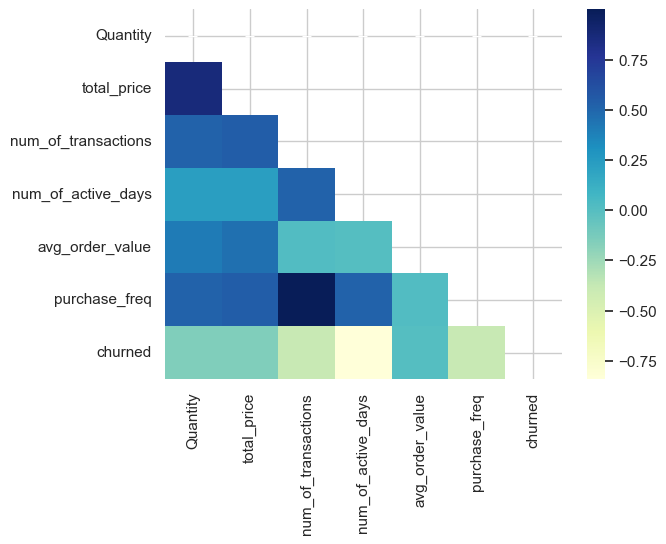

In [108]:
# let's create a correlation heatmap

data  = merged_two_years.drop(['Country', 'Customer ID'], axis=1)
 
print(data.corr()['churned'].sort_values(ascending=False))

# creating mask
mask = np.triu(np.ones_like(data.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, fmt=' .1f', mask=mask)
 
# displaying heatmap
plt.show()

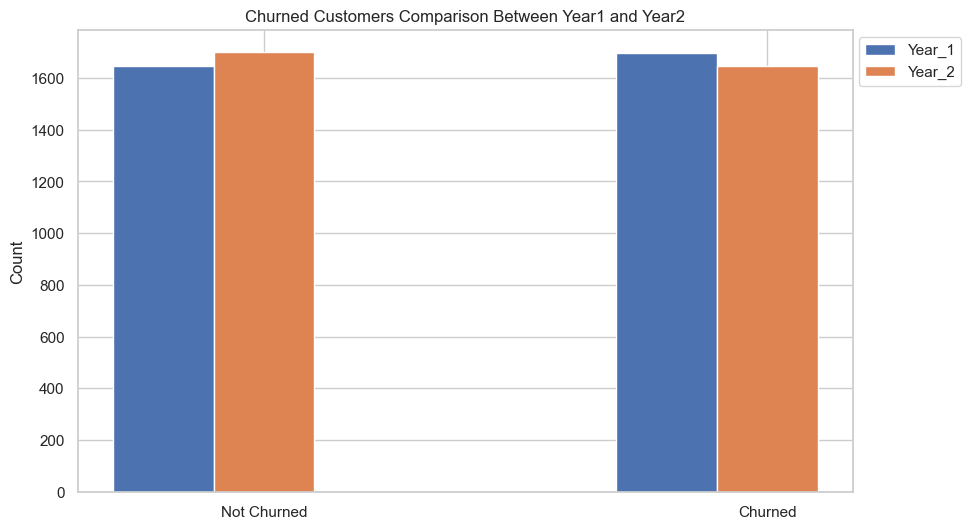

In [109]:
data1 = year_1_jan_to_jun['churned'].value_counts().sort_index()
data2 = year_2_jan_to_jun['churned'].value_counts().sort_index()

# Create a grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the bar width and bar positions
bar_width = 0.2
index = np.arange(len(data1))

# Adjust bar positions for each dataset
bar1 = ax.bar(index - bar_width, data1, bar_width, label='Year_1')
bar2 = ax.bar(index, data2, bar_width, label='Year_2')

# Add labels and a title
ax.set_ylabel('Count')
ax.set_title('Churned Customers Comparison Between Year1 and Year2')
ax.set_xticks(index)
ax.set_xticklabels(['Not Churned', 'Churned'])

# Add a legend
ax.legend(bbox_to_anchor = (1.15, 1))

# Show the plot
plt.show()

In [110]:
# removed Country column since there is no correlation and num_of_active_days which is the churned column's criterion.
# so as to avoid Label Leakage !!!!
X = merged_two_years.drop(['churned', 'Country', 'num_of_active_days'], axis=1)
y = merged_two_years['churned']

In [111]:
# Use of pycaret to identify top ml models for classification
from pycaret.classification import *
s = setup(data = X, target = y, session_id = 42)

,Description,Value
0,Session id,42
1,Target,churned
2,Target type,Binary
3,Original data shape,"(6693, 7)"
4,Transformed data shape,"(6693, 7)"
5,Transformed train set shape,"(4685, 7)"
6,Transformed test set shape,"(2008, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [112]:
best = compare_models()
print(best)

# NOTE: Any of the first 8 would work. Let's go with Extreme Gradient Boosting.
# (tested to work perfectly with classification issues)  
# ALSO A GOOD EXAMPLE OF HOW HYPERPARAMETER TUNING OPERATES!

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:58:30
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9355,0.9722,0.8787,0.9914,0.9315,0.8711,0.8768,0.7460
gbc,Gradient Boosting Classifier,0.9355,0.9737,0.8770,0.9933,0.9314,0.8711,0.8772,0.7640
rf,Random Forest Classifier,0.9330,0.9697,0.8842,0.9798,0.9295,0.8659,0.8702,0.7680
et,Extra Trees Classifier,0.9321,0.9709,0.8889,0.9730,0.9290,0.8642,0.8676,0.7940
lightgbm,Light Gradient Boosting Machine,0.9291,0.9703,0.8872,0.9683,0.9259,0.8583,0.8614,0.8830
xgboost,Extreme Gradient Boosting,0.9283,0.9704,0.8902,0.9638,0.9254,0.8566,0.8592,0.7510
lr,Logistic Regression,0.9165,0.9726,0.9035,0.9278,0.9154,0.8331,0.8336,1.2810
knn,K Neighbors Classifier,0.9131,0.9527,0.8898,0.9339,0.9111,0.8262,0.8276,0.8200
dt,Decision Tree Classifier,0.8993,0.8993,0.9005,0.8984,0.8994,0.7985,0.7986,0.7580
qda,Quadratic Discriminant Analysis,0.8149,0.9704,0.9739,0.7397,0.8405,0.6300,0.6648,0.7260


AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=1.0, n_estimators=50,
                   random_state=42)


In [113]:
# Classic train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [114]:
# Initialize the XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', seed=42)

# define scaler
scaler = StandardScaler()

# apply manually the scaler 
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 2, 3],
}

cv = GridSearchCV(estimator = model, param_grid=param_grid, cv=5, n_jobs=-1)

cv.fit(X_train, y_train)
best_cv = cv.best_estimator_

# dump the model to pickle format  
joblib.dump(best_cv, 'final_churn_xgb.pkl')

['final_churn_xgb.pkl']

In [115]:
# load it 
churn_loaded_model = joblib.load('final_churn_xgb.pkl')
churn_loaded_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 42}

In [116]:
# Make predictions on the test set using the best estimator
y_pred = best_cv.predict(X_test)

Precision        :  1.0 

Recall           :  0.8587570621468926 

F1-Score         :  0.9240121580547112 



array([[1147,    0],
       [ 150,  912]], dtype=int64)

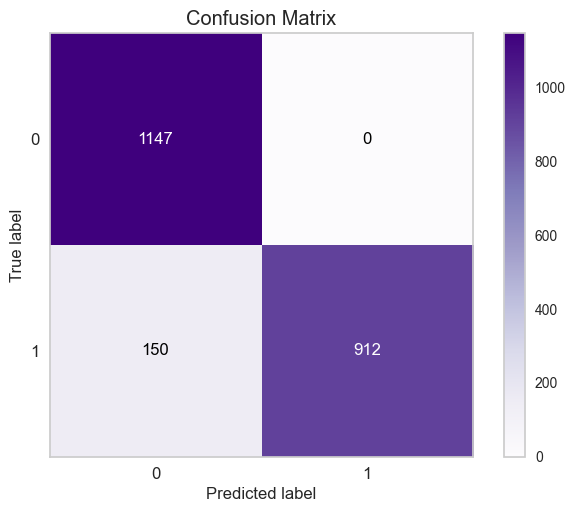

In [117]:
print('Precision        : ', precision_score(y_test, y_pred), "\n")
print('Recall           : ', recall_score(y_test, y_pred), "\n")
print('F1-Score         : ', f1_score(y_test, y_pred), "\n")

skplt.metrics.plot_confusion_matrix(y_test, y_pred,
                                    normalize=False,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    );

confusion_matrix(y_test, y_pred)

# NOTE: FROM 0.9638 TO 1.0

- Forecasting of weekly sales (times-series forecasting).  

In [ ]:
# NOTE : 
# Let's use the Facebook Prophet model ---> y = g(t) + s(t) + h(t) + εi 
# 3 core functions and an error term: 
 
# y    = Future Value(s)
# g(t) = Trend changes that DO NOT repeat.
# s(t) = Repeated seasonal changes.
# h(t) = Irregular changes like a holiday. 
# εi   = Leftover unique errors that cannot be explained.


# Time series forecasting  prophet model needs dataframe with 2 columns !!!!!!!

In [118]:
year_1['total_price'] = np.vectorize(total_price)(year_1['Quantity'], year_1['Price'])

In [119]:
year_2['total_price'] = np.vectorize(total_price)(year_2['Quantity'], year_2['Price'])

In [120]:
# Resample to weekly intervals and calculate the sum for each week
weekly_year_1 = year_1.resample('W-Mon', on='InvoiceDate').sum()

weekly_year_1 = weekly_year_1.reset_index()

# Check the resulting DataFrame
weekly_year_1 = weekly_year_1[['InvoiceDate', 'total_price']]

weekly_year_1.head()

,InvoiceDate,total_price
0,2009-12-07,226372.12
1,2009-12-14,191989.46
2,2009-12-21,152646.29
3,2009-12-28,28499.00
4,2010-01-04,6623.31


In [121]:
# Resample to weekly intervals and calculate the sum for each week
weekly_year_2 = year_2.resample('W-Mon', on='InvoiceDate').sum()

weekly_year_2 = weekly_year_2.reset_index()

# Check the resulting DataFrame
weekly_year_2 = weekly_year_2[['InvoiceDate', 'total_price']]

weekly_year_2.head(20)

,InvoiceDate,total_price
0,2010-12-06,205749.93
1,2010-12-13,254311.35
2,2010-12-20,171990.54
3,2010-12-27,49815.86
4,2011-01-03,0.00
5,2011-01-10,128618.23
6,2011-01-17,157426.34
7,2011-01-24,189992.42
8,2011-01-31,106209.12
9,2011-02-07,110862.65


In [122]:
# Create two line plots
fig = go.Figure()

# Add the first line plot
fig.add_trace(go.Scatter(x=weekly_year_1['InvoiceDate'], y=weekly_year_1['total_price'], mode='lines', name='Year 1'))

# Add the second line plot
fig.add_trace(go.Scatter(x=weekly_year_2['InvoiceDate'], y=weekly_year_2['total_price'], mode='lines', name='Year 2'))

# Find max and min values for each year
max_year_1 = weekly_year_1['total_price'].max()
min_year_1 = weekly_year_1['total_price'].min()
max_year_2 = weekly_year_2['total_price'].max()
min_year_2 = weekly_year_2['total_price'].min()

# Add annotations for max and min values
fig.add_annotation(x=weekly_year_1.loc[weekly_year_1['total_price'] == max_year_1, 'InvoiceDate'].values[0],
                   y=max_year_1,
                   text=f'Max Year 1: {max_year_1}',
                   showarrow=True,
                   arrowhead=1)
fig.add_annotation(x=weekly_year_1.loc[weekly_year_1['total_price'] == min_year_1, 'InvoiceDate'].values[0],
                   y=min_year_1,
                   text=f'Min Year 1: {min_year_1}',
                   showarrow=True,
                   arrowhead=1)
fig.add_annotation(x=weekly_year_2.loc[weekly_year_2['total_price'] == max_year_2, 'InvoiceDate'].values[0],
                   y=max_year_2,
                   text=f'Max Year 2: {max_year_2}',
                   showarrow=True,
                   arrowhead=1)
fig.add_annotation(x=weekly_year_2.loc[weekly_year_2['total_price'] == min_year_2, 'InvoiceDate'].values[0],
                   y=min_year_2,
                   text=f'Min Year 2: {min_year_2}',
                   showarrow=True,
                   arrowhead=1)

# Customize the layout
fig.update_layout(title='Total Price Comparison',
                  xaxis_title='Invoice Date',
                  yaxis_title='Total Price')

# Show the figure
fig.show()

In [123]:
model=Prophet() 

In [124]:
df = pd.merge(weekly_year_1, weekly_year_2, how='outer')
df.head() 

,InvoiceDate,total_price
0,2009-12-07,226372.12
1,2009-12-14,191989.46
2,2009-12-21,152646.29
3,2009-12-28,28499.00
4,2010-01-04,6623.31


In [125]:
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2009-12-07,226372.12
1,2009-12-14,191989.46
2,2009-12-21,152646.29
3,2009-12-28,28499.00
4,2010-01-04,6623.31


In [126]:
model.fit(df)
model.component_modes

19:19:50 - cmdstanpy - INFO - Chain [1] start processing
19:19:50 - cmdstanpy - INFO - Chain [1] done processing


{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [127]:
future_dates = model.make_future_dataframe(periods=365,freq='d',include_history=True)
print(future_dates.shape)
future_dates.head()

(471, 1)


,ds
0,2009-12-07
1,2009-12-14
2,2009-12-21
3,2009-12-28
4,2010-01-04


In [128]:
prediction=model.predict(future_dates)
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-12-07,137797.452562,206232.765464,280110.034266,137797.452562,137797.452562,104972.871199,104972.871199,104972.871199,104972.871199,104972.871199,104972.871199,0.0,0.0,0.0,242770.323761
1,2009-12-14,138220.692907,161617.909990,236494.423618,138220.692907,138220.692907,59801.635551,59801.635551,59801.635551,59801.635551,59801.635551,59801.635551,0.0,0.0,0.0,198022.328458
2,2009-12-21,138643.933252,77742.792577,158523.084416,138643.933252,138643.933252,-20041.555019,-20041.555019,-20041.555019,-20041.555019,-20041.555019,-20041.555019,0.0,0.0,0.0,118602.378233
3,2009-12-28,139067.173597,7969.214284,85597.579993,139067.173597,139067.173597,-92437.003225,-92437.003225,-92437.003225,-92437.003225,-92437.003225,-92437.003225,0.0,0.0,0.0,46630.170372
4,2010-01-04,139490.413923,-5812.181558,68161.876572,139490.413923,139490.413923,-107447.559101,-107447.559101,-107447.559101,-107447.559101,-107447.559101,-107447.559101,0.0,0.0,0.0,32042.854822


In [129]:
trace_open = go.Scatter(
    x = prediction["ds"],
    y = prediction["yhat"],
    mode = 'lines',
    name="Forecast"
)
trace_high = go.Scatter(
    x = prediction["ds"],
    y = prediction["yhat_upper"],
    mode = 'lines',
    fill = "tonexty", 
    line = {"color": "#57b8ff"}, 
    name="Higher uncertainty interval"
)
trace_low = go.Scatter(
    x = prediction["ds"],
    y = prediction["yhat_lower"],
    mode = 'lines',
    fill = "tonexty", 
    line = {"color": "#57b8ff"}, 
    name="Lower uncertainty interval"
)
trace_close = go.Scatter(
    x = df["ds"],
    y = df["y"],
    name="Data values"
)

#make list for all three scattle objects.
data = [trace_open,trace_high,trace_low,trace_close]
# Construct a new Layout object. 
#title - It will display string as a title of graph
layout = go.Layout(title="Power consumption forecasting")
#A list or tuple of trace instances (e.g. [Scatter(…), Bar(…)]) or A single trace instance (e.g. Scatter(…), Bar(…), etc.)
#A list or tuple of dicts of string/value properties where: - The ‘type’ property specifies the trace type.

fig = go.Figure(data=data)

# Customize the layout
fig.update_layout(title='Uncertainty Levels for Price Range for 2 Years',
                  xaxis_title='Invoice Date',
                  yaxis_title='Total Price')

fig.show()

In [130]:
fig = go.Figure([go.Scatter(x=df['ds'], y=df['y'],mode='lines',
                    name='Actual')])

#You can add traces using an Express plot by using add_trace
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat'],
                   mode='lines+markers',
                    name='predicted'))

#To display a figure using the renderers framework, you call the .show() method on a graph object figure, or pass the figure to the plotly.io.show function. 
#With either approach, plotly.py will display the figure using the current default renderer(s).

# Customize the layout
fig.update_layout(title='Actual vs Predicted Price for 2 Years',
                  xaxis_title='Invoice Date',
                  yaxis_title='Total Price')


fig.show()

In [131]:
#Return a Numpy representation of the DataFrame.
y_true = df['y'].values

#Here we have specified [:108] because in y_true we have 108 data points so for comparing both series we need equal shape of series.
y_pred = prediction['yhat'][:108].values 

mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 33686.253


In [132]:
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-12-07,137797.452562,206232.765464,280110.034266,137797.452562,137797.452562,104972.871199,104972.871199,104972.871199,104972.871199,104972.871199,104972.871199,0.0,0.0,0.0,242770.323761
1,2009-12-14,138220.692907,161617.909990,236494.423618,138220.692907,138220.692907,59801.635551,59801.635551,59801.635551,59801.635551,59801.635551,59801.635551,0.0,0.0,0.0,198022.328458
2,2009-12-21,138643.933252,77742.792577,158523.084416,138643.933252,138643.933252,-20041.555019,-20041.555019,-20041.555019,-20041.555019,-20041.555019,-20041.555019,0.0,0.0,0.0,118602.378233
3,2009-12-28,139067.173597,7969.214284,85597.579993,139067.173597,139067.173597,-92437.003225,-92437.003225,-92437.003225,-92437.003225,-92437.003225,-92437.003225,0.0,0.0,0.0,46630.170372
4,2010-01-04,139490.413923,-5812.181558,68161.876572,139490.413923,139490.413923,-107447.559101,-107447.559101,-107447.559101,-107447.559101,-107447.559101,-107447.559101,0.0,0.0,0.0,32042.854822


In [133]:
# ONLY 3 VALUES FOR AUTOMATIC HYPERPARAMETER TUNING !!!!!!!!
param_grid = {  
'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
'seasonality_mode': ['multiplicative', 'additive']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

mapes = []

for params in all_params:
    m = Prophet(**params).fit(df)
    df_cv = cross_validation(m, initial = '365 days', period = '30 days', horizon = '30 days', parallel = 'processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mae'].values[0])
    
tuning_results = pd.DataFrame(all_params)    
tuning_results['mae'] = mapes

best_params = all_params[np.argmin(mapes)]
print(best_params)

19:20:47 - cmdstanpy - INFO - Chain [1] start processing
19:20:47 - cmdstanpy - INFO - Chain [1] done processing
19:20:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:47 - cmdstanpy - INFO - Chain [1] start processing
19:20:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:21:00 - cmdstanpy - INFO 

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'seasonality_mode': 'additive'}


In [134]:
auto_model = Prophet(changepoint_prior_scale = best_params['changepoint_prior_scale'],
                     seasonality_prior_scale = best_params['seasonality_prior_scale'],
                     seasonality_mode        = best_params['seasonality_mode']        
)

joblib.dump(auto_model, "auto_model_prophet.pkl")

['auto_model_prophet.pkl']

In [135]:
auto_model.fit(df)

auto_model_cv = cross_validation(auto_model, initial = '365 days', period = '30 days', horizon = '30 days', parallel = 'processes')

auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p['mae'].values[0]

19:26:22 - cmdstanpy - INFO - Chain [1] start processing
19:26:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


29935.972254415254

In [ ]:
# NOTE : REDUCED MEAN ABSOLUTE ERROR AFTER HYPERPARAMETER TUNING ! 

In [136]:
# load the trained Prophet model
prophet_final = joblib.load('auto_model_prophet.pkl')  